In [ ]:
# Load the codebooks + labeled maps from the three trained SOMs
# Load the COSMOS catalog
# Make predictions
# See how they match up

In [1]:
import os

import somoclu

from fitsio import FITS

import numpy as np
import numpy.lib.recfunctions as rcf

import matplotlib as mpl
import matplotlib.pyplot as plt

from cycler import cycler
plt.rcParams.update({
    'figure.figsize'   : (12, 10),
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   : 5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 7,
    'ytick.major.size' : 7,
    'xtick.major.width': 3,
    'ytick.major.width': 3,
    'xtick.minor.size' : 5,
    'ytick.minor.size' : 5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'lines.linewidth'  : 3,
    'axes.prop_cycle'  : cycler('color', ['red', 'orange', 'teal', 'skyblue']),
})

In [2]:
trained_SOM_folder = '/data2/lsajkov/mpdg/saved_soms/09Aug24_mag_cut_20p5'

In [3]:
#set parameters
n_columns      = 48
n_rows         = 48

maptype        = 'toroid'
gridtype       = 'hexagonal'

initialization = 'pca'

neighborhood   = 'gaussian'
std_coeff      = 0.5

verbose        = 2

compactsupport = False

#training parameters
epochs        = 50

radius0       = 0
radiusN       = 1
radiuscooling = 'exponential'

scale0        = 0.25
scaleN        = 0.01
scalecooling  = 'exponential'

In [4]:
SOM = somoclu.Somoclu(n_columns      = n_columns,
                      n_rows         = n_rows,
                      maptype        = maptype,
                      gridtype       = gridtype,
                      initialization = initialization,
                      neighborhood   = neighborhood,
                      std_coeff      = std_coeff,
                      verbose        = verbose,
                      compactsupport = compactsupport)

In [5]:
SOM.codebook = np.load(f'{trained_SOM_folder}/SOM_codebook.npy', allow_pickle = True)
labeled_map  = np.load(f'{trained_SOM_folder}/labeled_map.npy', allow_pickle = True)

In [15]:
full_COSMOS_cat = FITS('/data2/lsajkov/mpdg/data/COSMOS/COSMOS2020_CLASSIC_R1_v2.2_p3.fits')[1]

mag_cut = full_COSMOS_cat['HSC_r_MAG_AUTO'][:] < 22.5
redshift_cut = full_COSMOS_cat['lp_zPDF'][:] < 0.4

bands = ['CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks']

band_cut = np.full(full_COSMOS_cat.get_nrows(), 1, dtype = bool)
for band in bands:
    band_cut = band_cut & (~np.isnan(full_COSMOS_cat[f'{band}_MAG_AUTO'][:]))

cut_idx = np.arange(0, full_COSMOS_cat.get_nrows())[mag_cut & redshift_cut & band_cut]

In [16]:
r_mag = full_COSMOS_cat['HSC_r_MAG_AUTO'][cut_idx]

In [17]:
bands = ['CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks']

magnitude_aper_names = [band + '_MAG_APER2' for band in bands]
magnitudes_aper = full_COSMOS_cat[magnitude_aper_names][cut_idx]

colors = np.zeros(len(magnitudes_aper), dtype = np.dtype([('placeholder', '<f4')]))

for i, band_hi in enumerate(bands):
    for band_lo in bands[i + 1:]:
        color = np.array(magnitudes_aper[f'{band_hi}_MAG_APER2'] - magnitudes_aper[f'{band_lo}_MAG_APER2'])
        colors = rcf.append_fields(colors, f'{band_hi.split('_')[1]}{band_lo.split('_')[1]}_col', color)
colors = rcf.drop_fields(colors, 'placeholder')     

In [18]:
half_light_radius = full_COSMOS_cat['FLUX_RADIUS'][cut_idx]
half_light_radius *= 0.15
redshift = full_COSMOS_cat['lp_zPDF'][cut_idx]

In [19]:
COSMOS_SOM_data = r_mag
COSMOS_SOM_data = rcf.append_fields(COSMOS_SOM_data, colors.dtype.names, [colors[name] for name in colors.dtype.names])
COSMOS_SOM_data = rcf.append_fields(COSMOS_SOM_data, 'half_light_radius', half_light_radius)
COSMOS_SOM_data = rcf.append_fields(COSMOS_SOM_data, 'redshift', redshift)

COSMOS_SOM_data = rcf.structured_to_unstructured(COSMOS_SOM_data)

In [20]:
activation_map = SOM.get_surface_state(data = COSMOS_SOM_data)
COSMOS_bmus = SOM.get_bmus(activation_map = activation_map)

In [21]:
COSMOS_predicted_values = np.empty((len(COSMOS_bmus), 2))

for i, bmu in enumerate(COSMOS_bmus):
    COSMOS_predicted_values[i] = labeled_map[*bmu]

In [22]:
COSMOS_SED_vals = full_COSMOS_cat[['lp_zPDF', 'lp_mass_med']][cut_idx]
COSMOS_SED_vals['lp_mass_med'] -= 2*np.log10(0.7)

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
/var/tmp/lsajkov/ipykernel_796680/4189509336.py:37: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_xlabel('SED $\log_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_796680/4189509336.py:38: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_ylabel('SOM $\log_{10} (M_*/M_{\odot})$')


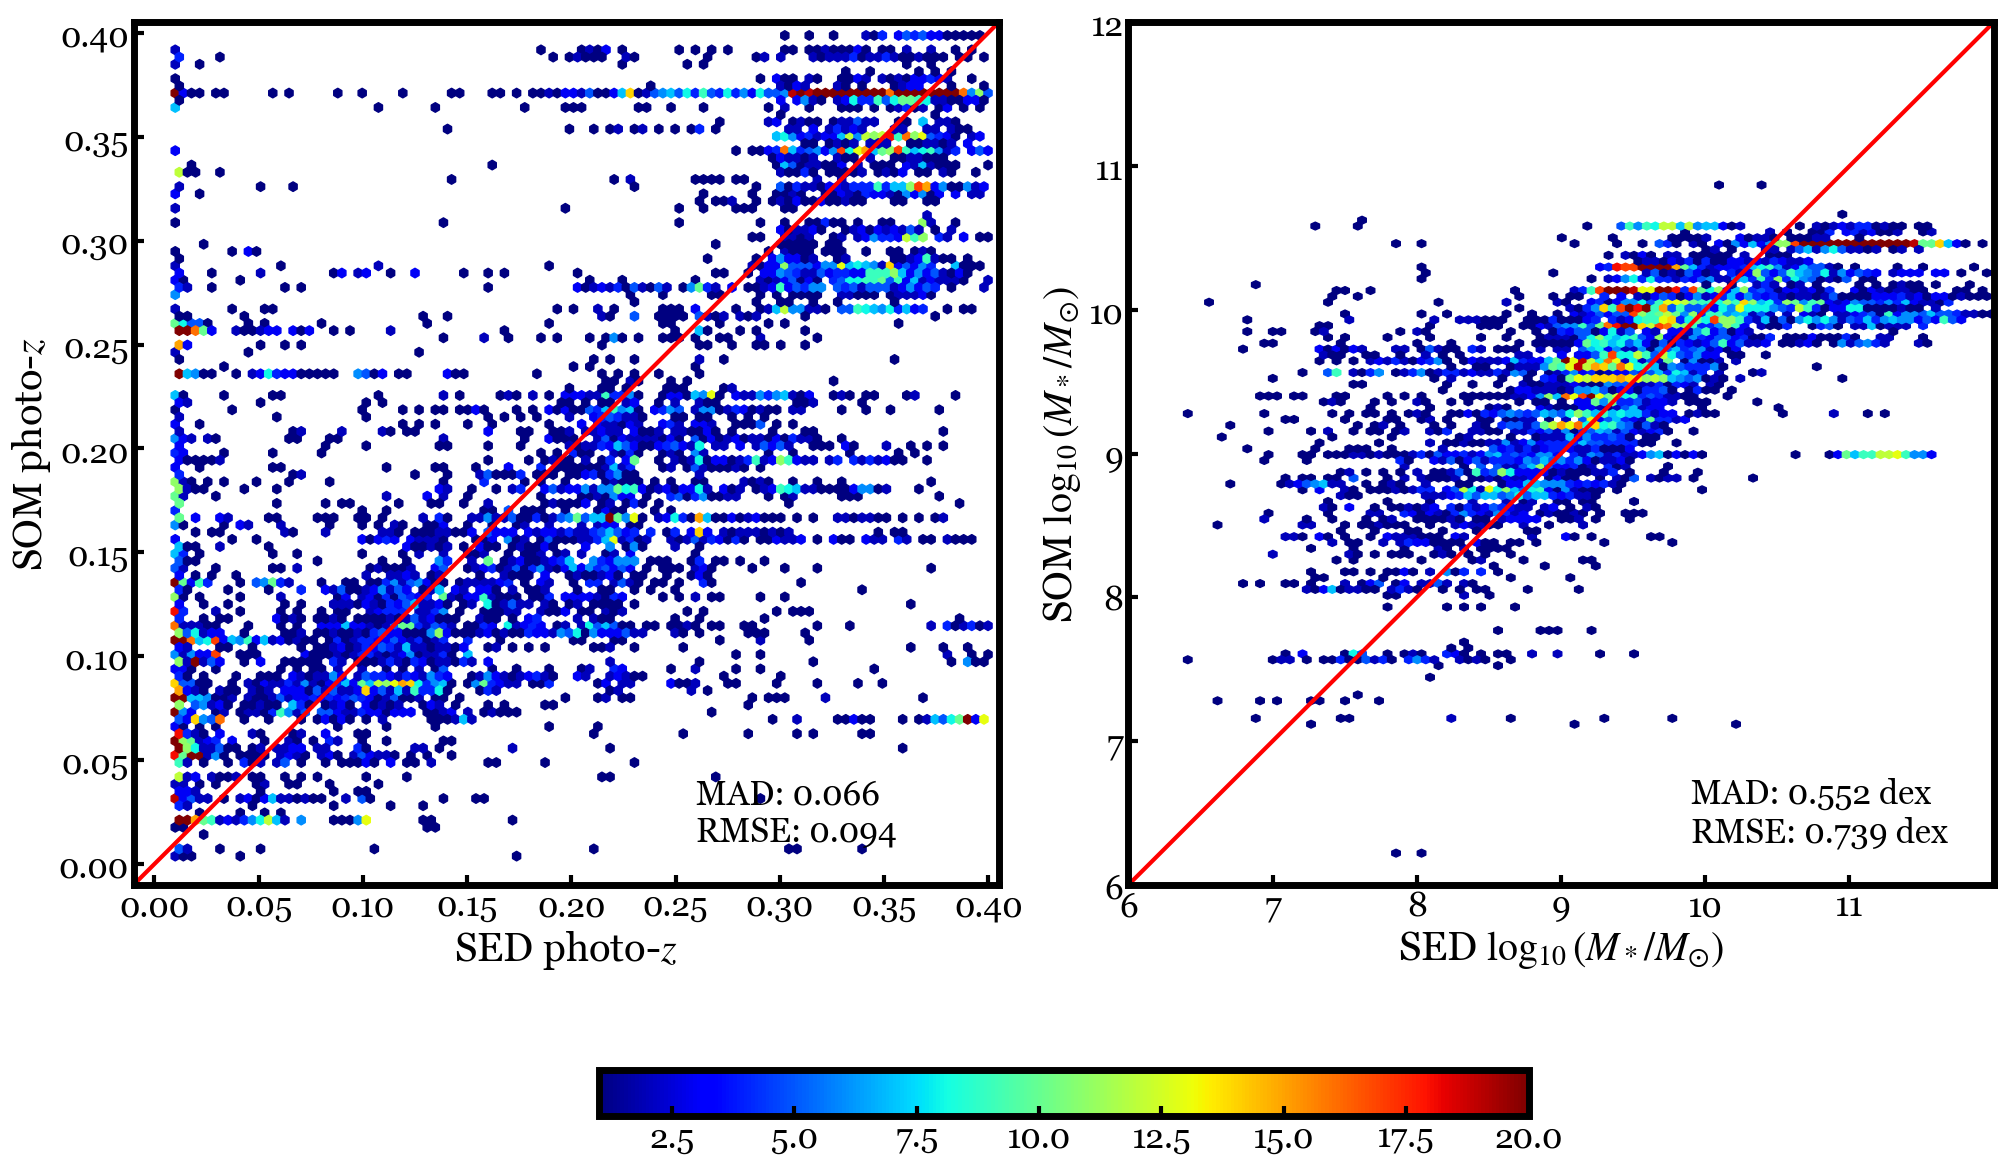

In [23]:
fig = plt.figure(figsize = (24, 16))

ax_l = fig.add_subplot(1, 2, 1)

hb_l = ax_l.hexbin(COSMOS_SED_vals['lp_zPDF'],
                   COSMOS_predicted_values[:, 0],
                   mincnt = 1, cmap = 'jet',
                   vmin = 1, vmax = 20)

ax_l.axline([0.2, 0.2], slope = 1, color = 'red')
ax_l.set_xlim(-0.01, 0.405)
ax_l.set_ylim(-0.01, 0.405)
ax_l.set_xticks(np.arange(0, 0.45, 0.05))

ax_l.set_xlabel('SED photo-$z$\n')
ax_l.set_ylabel('SOM photo-$z$')

z_MAD = np.nanmean(np.abs(COSMOS_predicted_values[:, 0] - COSMOS_SED_vals['lp_zPDF']))
z_RMSE = np.sqrt(np.nanmean((COSMOS_predicted_values[:, 0] - COSMOS_SED_vals['lp_zPDF']) ** 2))

ax_l.text(0.65, 0.05, f'MAD: {z_MAD:.3f}\nRMSE: {z_RMSE:.3f}',
          transform = ax_l.transAxes)


ax_r = fig.add_subplot(1, 2, 2)

hb_r = ax_r.hexbin(COSMOS_SED_vals['lp_mass_med'],
                   COSMOS_predicted_values[:, 1],
                   mincnt = 1, cmap = 'jet',
                   vmin = 1, vmax = 20)

ax_r.axline([10, 10], slope = 1, color = 'red')
ax_r.set_xlim(6, 12)
ax_r.set_ylim(6, 12)
ax_r.set_xticks(np.arange(6, 12, 1))

ax_r.set_xlabel('SED $\log_{10} (M_*/M_{\odot})$')
ax_r.set_ylabel('SOM $\log_{10} (M_*/M_{\odot})$')

Mstar_MAD = np.nanmean(np.abs(COSMOS_predicted_values[:, 1] - COSMOS_SED_vals['lp_mass_med']))
Mstar_RMSE = np.sqrt(np.nanmean((COSMOS_predicted_values[:, 1] - COSMOS_SED_vals['lp_mass_med']) ** 2))

ax_r.text(0.65, 0.05, f'MAD: {Mstar_MAD:.3f} dex\nRMSE: {Mstar_RMSE:.3f} dex',
          transform = ax_r.transAxes)

fig.subplots_adjust(wspace = 0.15)

fig.colorbar(mappable = hb_l, location = 'bottom', ax = [ax_l, ax_r], shrink = 0.5)

# fig.savefig(f'{folder_name}/comparison.png', bbox_inches = 'tight')